# Import libraries

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns # seaborn package to generate nice plots
import matplotlib.pyplot as plt
from scipy.stats import skew,norm

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Reading the data

In [2]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
train.head()

,Id,date,company_code,company,yesterday_price,open,last,close,low,high,qty_traded,num_trades,value,next_day_ret
0,0,2018-01-02,725001,ADWYA,5.35,5.25,5.39,5.39,5.25,5.39,2926,7,15635.50,-161.101159
1,1,2018-01-02,340005,AMEN BANK,24.35,24.38,24.00,24.00,24.00,24.38,1519,12,36918.00,-91.056323
2,2,2018-01-02,730001,ARTES,6.20,6.27,6.10,6.10,6.09,6.27,35875,67,219020.05,159.011983
3,3,2018-01-02,714001,ASSAD,9.00,0.00,0.00,9.00,0.00,0.00,0,0,NaN,-98.000768
4,4,2018-01-02,360035,ATB,4.22,4.15,4.18,4.18,4.15,4.18,3705,7,15465.90,-158.659992


In [3]:
print("train shape",train.shape)
print("train shape",test.shape)

train shape (20417, 14)
train shape (20331, 13)


# Data Processing 

First, we need to check the **NaN values** in both **train** and **test** datasets. 

In [4]:
print ("the number of missing values in train",train.isna().sum().sum())
print ("the number of missing values in test",test.isna().sum().sum())

the number of missing values in train 4492
the number of missing values in test 5560


Let s check where are the **NaN values**

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20417 entries, 0 to 20416
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               20417 non-null  int64  
 1   date             20417 non-null  object 
 2   company_code     20417 non-null  int64  
 3   company          20417 non-null  object 
 4   yesterday_price  20417 non-null  float64
 5   open             20417 non-null  float64
 6   last             20417 non-null  float64
 7   close            20417 non-null  float64
 8   low              20417 non-null  float64
 9   high             20417 non-null  float64
 10  qty_traded       20417 non-null  int64  
 11  num_trades       20417 non-null  int64  
 12  value            15925 non-null  float64
 13  next_day_ret     20417 non-null  float64
dtypes: float64(8), int64(4), object(2)
memory usage: 2.2+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20331 entries, 0 to 20330
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               20331 non-null  int64  
 1   date             20331 non-null  object 
 2   company_code     20331 non-null  int64  
 3   company          20331 non-null  object 
 4   yesterday_price  20331 non-null  float64
 5   open             20331 non-null  float64
 6   last             20331 non-null  float64
 7   close            20331 non-null  float64
 8   low              20331 non-null  float64
 9   high             20331 non-null  float64
 10  qty_traded       20331 non-null  int64  
 11  num_trades       20331 non-null  int64  
 12  value            14771 non-null  float64
dtypes: float64(7), int64(4), object(2)
memory usage: 2.0+ MB


By looking at the output of both **train.info()** and **test.info()** we see that the **NaN values**  are in the **"value" feature**.

In [7]:
train["value"]=train["value"].fillna('0')
test["value"]=test["value"].fillna('0')

In [8]:
print ("the number of missing values in train",train.isna().sum().sum())
print ("the number of missing values in test",test.isna().sum().sum())

the number of missing values in train 0
the number of missing values in test 0


As we see , there are no more **NaN values**

Now we'll add a new column **"currReturn"** for a better performance of the model.

In [9]:
train['currReturn']=train.groupby(['company'])['close'].pct_change()
test['currReturn']=test.groupby(['company'])['close'].pct_change()

In [10]:
print ("the number of missing values in currReturn",train['currReturn'].isnull().sum().sum())
print ("the number of missing values in currReturn",test['currReturn'].isnull().sum().sum())

the number of missing values in currReturn 82
the number of missing values in currReturn 82


As we see the new column in both of the train and the test contains missing values.

In [11]:
train["currReturn"]=train["currReturn"].fillna('0')
test["currReturn"]=test["currReturn"].fillna('0')

In [12]:
print ("the number of missing values in train",train.isna().sum().sum())
print ("the number of missing values in test",test.isna().sum().sum())

the number of missing values in train 0
the number of missing values in test 0


Now let s check the **correlation** between the features.

In [13]:
corrmat=train.corr()

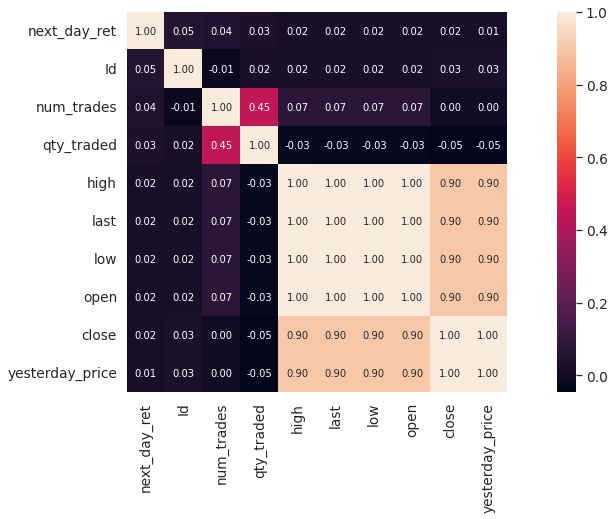

In [14]:
cols = corrmat.nlargest(10, 'next_day_ret')['next_day_ret'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
plt.figure(figsize = (18,7))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

We see that there is a strong correlation between these features **open** , **last** , **low** , **high** , **close** , **yesterday_price**.  
The **Numerical features** have low correlation with the **target** and we'll chek this later in this notebook.

As the features **Id** and **company** are useless for the training of the model, we'll drop them.

In [15]:
train_ID=train["Id"]
test_ID=test["Id"]

In [16]:
train.drop("company",axis=1,inplace=True)
train.drop("Id",axis=1,inplace=True)
test.drop("Id",axis=1,inplace=True)
test.drop("company",axis=1,inplace=True)

### Relation of features to target

In [17]:
numerical_feats = train.dtypes[train.dtypes != "object"].index
numerical_feats

Index(['company_code', 'yesterday_price', 'open', 'last', 'close', 'low',
       'high', 'qty_traded', 'num_trades', 'next_day_ret'],
      dtype='object')

Now, let's see the **regplot** between the **numerical features** and the **target**.

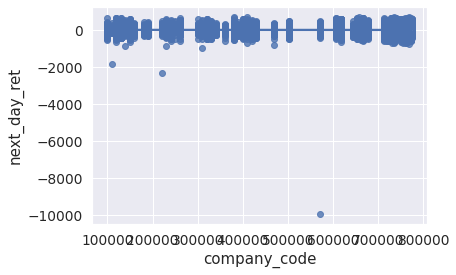

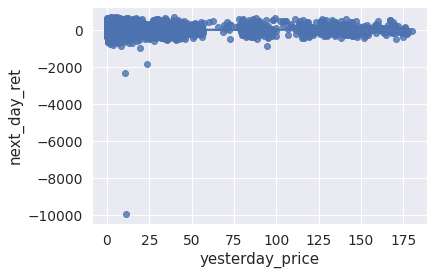

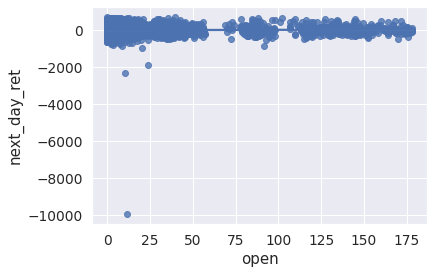

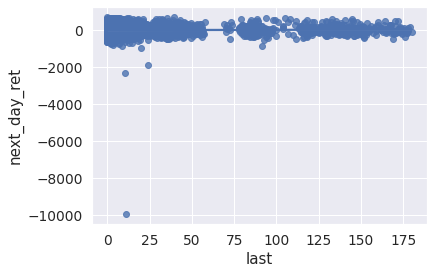

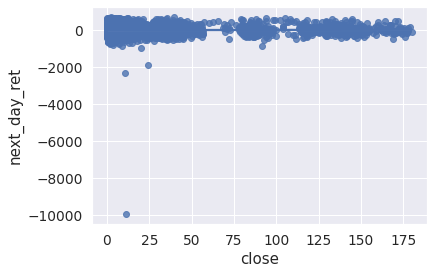

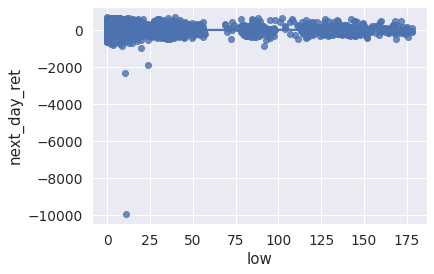

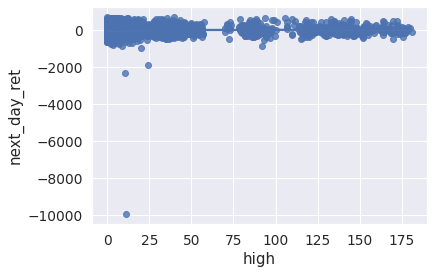

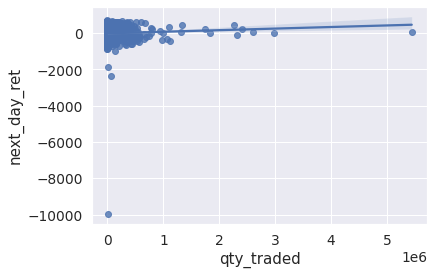

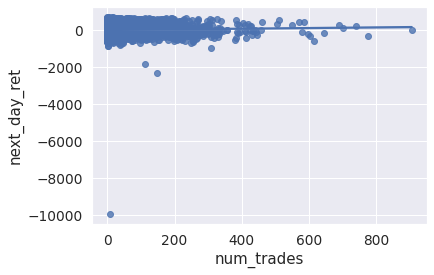

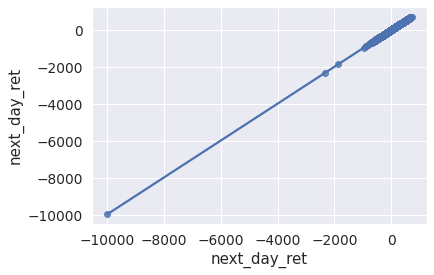

In [18]:
for var in numerical_feats:
    ax = sns.regplot(x=var, y="next_day_ret", data=train)
    plt.plot
    plt.show()

By looking to this plot , we see that there are some **outliers** to remove. We 'll remove the outliers of  **"qty_traded"**.  
As there is a strong correlation between these features **open** , **last** , **low** , **high** , **close** , **yesterday_price**, we see that they have the same distribution with the **target**.


In [19]:
#qty_traded
train = train.drop(train[(train['qty_traded']>400000)].index)

### The target : "next_day_ret"

Let's see the distribution of the target


 mu = -4.97 and sigma = 191.70



Text(0.5, 1.0, 'next_day_ret')

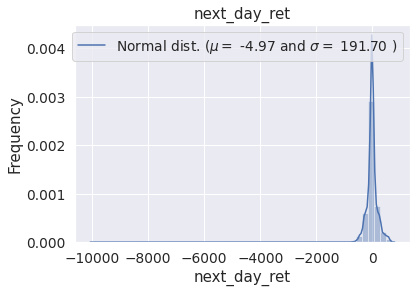

In [20]:
from scipy.stats import norm
sns.distplot(train['next_day_ret'] );
(mu, sigma) = norm.fit(train['next_day_ret'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('next_day_ret')

By looking to the plot, we 're sure that the **target** has **no normal distribution**, and to check that let's do a **statistic test** using **Jarque_Bera test** in which :  
**H0** : The **target** has normal distribution  
**HA** : The **target** has no normal distribution

In [21]:
import statsmodels.stats.api as sms
Jarque_Bera_target=pd.DataFrame(sms.jarque_bera(train["next_day_ret"]),index=["JB_Value","p_value","skew","kurtosis"],columns=["target"])
Jarque_Bera_target

,target
JB_Value,1.118570e+08
p_value,0.000000e+00
skew,-6.817276e+00
kurtosis,3.659070e+02


The **p-value** is **0** which is less than 0.01. So we reject the null hypothesis with very strong evidence. So the **target** has **no normal distribution**.  
In order the get the distribution closed the a **normal** distribution , we'll remove some **outliers** from the **target**.

In [22]:
train=train[abs(train['next_day_ret'])<1000]


 mu = -4.27 and sigma = 177.26



Text(0.5, 1.0, 'next_day_ret')

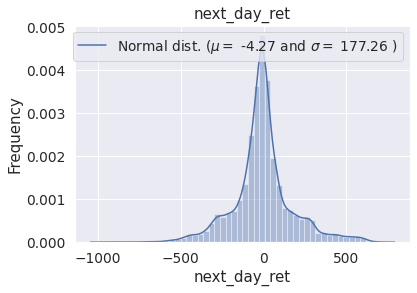

In [23]:
sns.distplot(train['next_day_ret'] );
(mu, sigma) = norm.fit(train['next_day_ret'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('next_day_ret')

Now, as we see by removing the **outliers** from the **target** the distribution got closed to a **Normal distribution**.

Now, let's drop the **target** column.

In [24]:
target=train["next_day_ret"]

In [25]:
train.drop("next_day_ret",axis=1,inplace=True)

Now it's time to concatenate both **train** and **test** datasets.

In [26]:
X_all=pd.concat([train,test])

In [27]:
X_all.shape

(40683, 12)

### The skew of the numerical features

One of the most important steps in data processing is checking the **skewness** of the **numerical features**.

In [28]:
num_feats=['yesterday_price', 'open', 'last', 'close', 'low', 'high','qty_traded', 'num_trades']
skewed_feats = X_all[num_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
qty_traded,81.170438
num_trades,4.815775
high,4.673373
last,4.664056
open,4.661589
low,4.649412
yesterday_price,4.047027
close,4.045958


By looking to this table, all the **numerical feartures** have a skew greater than 1, so we'll apply **log1p** to reduce it.

In [29]:
skewness = skewness[abs(skewness) > 1]
skewed_features = skewness.index
for feat in skewed_features:
    X_all[feat] = np.log1p(X_all[feat])

Let's if there are **missing values** after these transformations.

In [30]:
print("the number of missing values is " ,X_all.isna().sum().sum())

the number of missing values is  0


### PCA

As we've checked before , there are many features which are **highly correlated** so we need  methods to represent these features with a less number of variables.One of these methodes is **PCA**. As the purpose of the **PCA** is **Linear dimensionality reduction** using **Singular Value Decomposition** of the data to project it to a **lower dimensional space**.  

To perform better our model, we'll use PCA but on only these features **open** , **last** , **low** , **high** , **close**, **yesterday_price**.

First, we create **data_pca** which contains only  **open** , **last** , **low** , **high** , **close**, **yesterday_price**.

In [31]:
data_pca=pd.DataFrame()

In [32]:
data_pca["open"]=X_all["open"]
data_pca["last"]=X_all["last"]
data_pca["low"]=X_all["low"]
data_pca["close"]=X_all["close"]
data_pca["yesterday_price"]=X_all["yesterday_price"]

In [33]:
data_pca.head()

,open,last,low,close,yesterday_price
0,1.832581,1.854734,1.832581,1.854734,1.848455
1,3.233961,3.218876,3.218876,3.218876,3.232779
2,1.983756,1.960095,1.958685,1.960095,1.974081
3,0.000000,0.000000,0.000000,2.302585,2.302585
4,1.638997,1.644805,1.638997,1.644805,1.652497


In order to make the **mean** of our data **0** and the **variance** **1**, we'll use **StandarScaler**.  

In [34]:
# StandardScaler from Scikit-Learn
from sklearn.preprocessing import StandardScaler

# Initialize instance of StandardScaler
scaler = StandardScaler()

# Fit and transform item_data
data_scaled = scaler.fit_transform(data_pca)

# Display first 5 rows of item_data_scaled
data_scaled[:5]

array([[ 0.20557516,  0.2222645 ,  0.21003832, -0.20834583, -0.21420749],
       [ 1.29766169,  1.28510955,  1.29223706,  1.06184844,  1.07504179],
       [ 0.32338474,  0.30435415,  0.30848022, -0.1102414 , -0.09720922],
       [-1.22254393, -1.22281658, -1.22055061,  0.20866189,  0.20873336],
       [ 0.05471579,  0.05870213,  0.05891805, -0.40381739, -0.39670665]])

Now, let's apply **PCA** on our **data_scaled**.

In [35]:
# Initialize instance of PCA transformation
from sklearn.decomposition import PCA
pca = PCA()

# Fit the instance
pca.fit(data_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [36]:
pca.components_

array([[ 0.46803555,  0.46801168,  0.46822834,  0.4139617 ,  0.41389096],
       [-0.33831767, -0.338461  , -0.33712933,  0.57317806,  0.57340739],
       [ 0.29412028, -0.3636999 ,  0.06989225, -0.62317943,  0.62287889],
       [ 0.69787746, -0.53987182, -0.15819702,  0.31353462, -0.31332924],
       [ 0.3048675 ,  0.49261549, -0.79824483, -0.11595714,  0.1172387 ]])

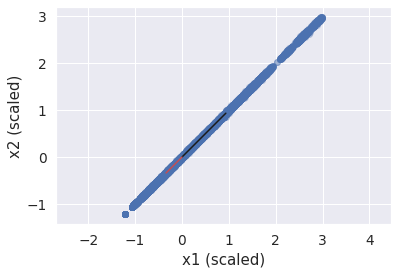

In [37]:
# Plot scaled dataset and make it partially transparent
plt.scatter(data_scaled[:,0], data_scaled[:,1], alpha=0.3)

# Plot first principal component in black
plt.plot([0, 2*pca.components_[0,0]], [0, 2*pca.components_[0,1]], 'k')

# Plot second principal component in red
plt.plot([0, pca.components_[1,0]], [0, pca.components_[1,1]], 'r')

# Set axes
plt.axis('equal')
plt.xlabel('x1 (scaled)')
plt.ylabel('x2 (scaled)')

# Clear text residue
plt.show()

In [38]:
# Generate new features
PC = pca.transform(data_scaled)

# Display first 5 rows
PC[:5]

array([[ 1.23679019e-01, -4.57835062e-01, -9.28219190e-03,
        -7.96166773e-03,  3.54789568e-03],
       [ 2.69837476e+00, -8.45672071e-02,  1.24904861e-02,
         3.47056513e-03,  6.57889239e-05],
       [ 3.52366298e-01, -4.35344945e-01,  1.41314175e-02,
         8.46403335e-03,  3.66291755e-03],
       [-1.54321196e+00,  1.47825700e+00, -1.61911770e-04,
         8.62916763e-05, -5.18302678e-04],
       [-2.50688909e-01, -5.17176495e-01,  3.41147518e-03,
        -5.13830640e-03, -1.11624887e-03]])

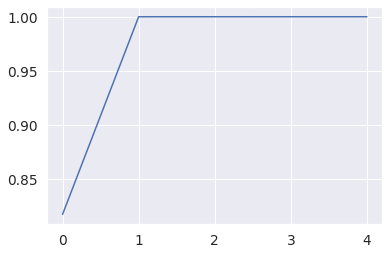

In [39]:
# Cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.plot(range(len(cumulative_explained_variance)), cumulative_explained_variance)

In [40]:
# How much variance we'd capture with the first two components
cumulative_explained_variance[1]

0.9999735013668627

In [41]:
explained_variance=pca.explained_variance_ratio_
explained_variance

array([8.17796354e-01, 1.82177147e-01, 1.86148088e-05, 4.13482098e-06,
       3.74900338e-06])

**99.99%** of the variance is explained by the first two PCs.  
 We know that the most of our data is represented by PC1 as **0.81>0.18**, so x axis is more significant compared to the y-axis.

Let's assert our informations by a plot.

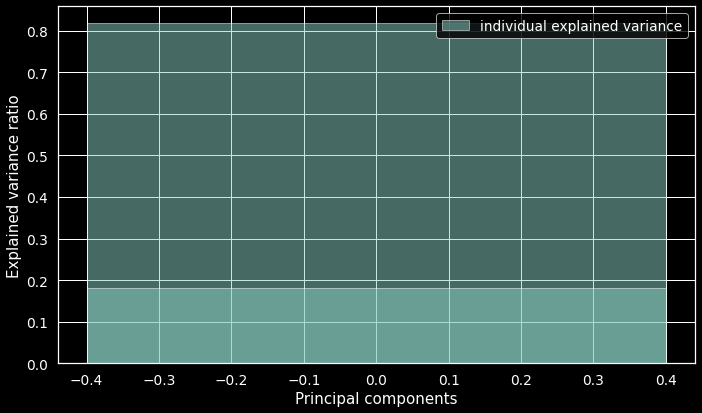

In [42]:
with plt.style.context('dark_background'):
    plt.figure(figsize=(10, 6))

    plt.bar(range(1), explained_variance, alpha=0.5, align='center',
            label='individual explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

In [43]:
# Initialize PCA transformation, only keeping 2 components
pca = PCA(n_components=2)

# Fit and transform item_data_scaled
PC_items = pca.fit_transform(data_scaled)

# Display shape of PC_items
PC_items.shape

(40683, 2)

In [44]:
print("original shape:   ", data_scaled.shape)
print("transformed shape:", PC_items.shape)

original shape:    (40683, 5)
transformed shape: (40683, 2)


The transformed data has been reduced to two dimensions. To understand the effect of this **dimensionality reduction**, we can perform the inverse transform of this **reduced data** and plot it along with the **original data**:

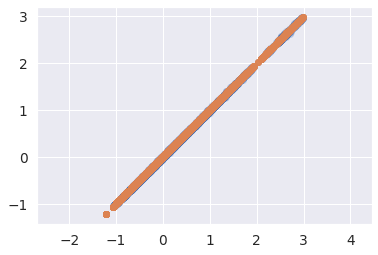

In [45]:
data_new = pca.inverse_transform(PC_items)
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], alpha=0.2)
plt.scatter(data_new[:, 0], data_new[:, 1], alpha=0.8)
plt.axis('equal');

The **blue points** are the **original data**, while the **green points** are the **projected version**. This makes clear what a PCA dimensionality reduction means: the information along the least important principal axis or axes is removed, leaving only the component(s) of the data with the highest variance.

As we 've mentioned before , 99.99 % of the variance is explained by the first two PCs.So we'll extract them and add them to **X_all** data.

In [46]:
# Put PC_items into a dataframe
items_pca = pd.DataFrame(PC_items)

# Name the columns
items_pca.columns = ['PC{}'.format(i + 1) for i in range(PC_items.shape[1])]

# Update its index
items_pca.index = X_all.index

# Display first 5 rows
items_pca.head()

,PC1,PC2
0,0.123679,-0.457835
1,2.698375,-0.084567
2,0.352366,-0.435345
3,-1.543212,1.478257
4,-0.250689,-0.517176


Now we'll add these these two columns **PC1** and **PC2** to **X_all** data.  

In [47]:
X_all["PC1"]=items_pca["PC1"]
X_all["PC2"]=items_pca["PC2"]

### Factor Analysis

As we 've mentioned before, **open** , **last** , **low** , **high** , **close**, **yesterday_price** are **highly correlated** ,we need to drop them but before that we'll do some **dimentionality reduction** using **factor analysis**.

#### The factorability evaluation

First, we need to evaluate the factorabilty of our dataset which means can we find the factors in the dataset.

So, we'll use **Bartlett’s** to test check whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix.

In [48]:
!pip install factor_analyzer

In [49]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(data_pca)
chi_square_value, p_value

(1205679.001275151, 0.0)

The **p-value** is 0. The test is statistically significant, indicating that the observed correlation matrix is not an identity matrix.

#### choosing the number of factors

Next step, we have to choose the number of factors , so we'll use the **Kaiser criterion** and **screen plot**. The method is based on the **eigen values**.

In [50]:
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer(rotation=None)
fa.fit(data_pca)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=3, rotation=None, rotation_kwargs={},
               svd_method='randomized', use_smc=True)

In [51]:
eigen_values, vectors = fa.get_eigenvalues()
eigen_values

array([4.08898177e+00, 9.10885737e-01, 9.30740439e-05, 2.06741049e-05,
       1.87450169e-05])

There is one factor eigenvalue is **greater than one** . So, we choose only **one** factor.

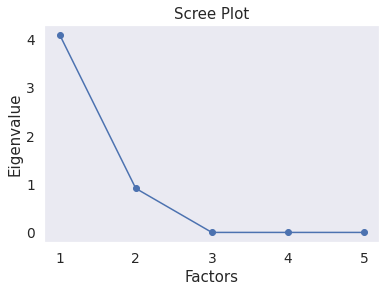

In [52]:
plt.scatter(range(1,data_pca.shape[1]+1),eigen_values)
plt.plot(range(1,data_pca.shape[1]+1),eigen_values)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

We 'll create a new column **factor1** which reduces the data represented by **open** , **last** , **low** , **high** , **close**, **yesterday_price**

In [53]:
features=['open','last','close','low','high','yesterday_price']
i=0
X_all['factor1']=0
for feat in features: 
    X_all['factor1']=X_all['factor1'] + fa.loadings_[:,0][i]*X_all[feat] + fa.loadings_[:,1][i]*X_all[feat]

Now , it's time to drop these columns **open** , **last** , **low** , **high** ,  **yesterday_price** from **X_all**.

In [54]:
X_all.drop("open",axis=1,inplace=True)
X_all.drop("last",axis=1,inplace=True)
X_all.drop("high",axis=1,inplace=True)
X_all.drop("low",axis=1,inplace=True)
X_all.drop("yesterday_price",axis=1,inplace=True)

In [55]:
print("the number of missing values is " ,X_all.isna().sum().sum())
print("the shape of X_all data after applying factor analysis " ,X_all.shape)

the number of missing values is  0
the shape of X_all data after applying factor analysis  (40683, 10)


We reach our purpose which is **dimentionality reduction**.

Now , let's drop the date to fit our **linear_regression_model**. But before that , let's check the correlation between the **new features**.

In [56]:
X_all.drop("date",axis=1,inplace=True)

In [57]:
X_all.corr()

,company_code,close,qty_traded,num_trades,PC1,PC2,factor1
company_code,1.000000,-0.426671,0.065497,0.008958,-3.171933e-01,-2.945924e-01,-0.295007
close,-0.426671,1.000000,-0.081250,0.029315,8.370815e-01,5.470431e-01,0.795364
qty_traded,0.065497,-0.081250,1.000000,0.921929,3.239450e-01,-6.443857e-01,0.369996
num_trades,0.008958,0.029315,0.921929,1.000000,3.824270e-01,-5.320100e-01,0.420323
PC1,-0.317193,0.837082,0.323945,0.382427,1.000000e+00,2.654595e-16,0.997385
PC2,-0.294592,0.547043,-0.644386,-0.532010,2.654595e-16,1.000000e+00,-0.072260
factor1,-0.295007,0.795364,0.369996,0.420323,9.973853e-01,-7.225963e-02,1.000000


We see that **PC1** and **factor1** are **highly correlated**.

### Split the data

In [58]:
len_train = train.shape[0]
train = pd.DataFrame(X_all[:len_train])
test = pd.DataFrame(X_all[len_train:])

In [59]:
# Dataframe dimensions
print(train.shape)
print("*"*50)
print(test.shape)

(20352, 9)
**************************************************
(20331, 9)


In [60]:
# split train dataset into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size = 0.2, random_state = 33)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((16281, 9), (4071, 9), (16281,), (4071,))

# Modeling

In [61]:
from sklearn.metrics import mean_squared_error
from sklearn import linear_model 

In [62]:
lr = linear_model.LinearRegression() 
lr.fit(X_train,y_train) 
preds = lr.predict(X_test)

In [63]:
val_mae =np.sqrt(mean_squared_error( y_test, preds ))
print("the validation error is " , val_mae)

the validation error is  173.88965402357994


0.04278957152554019

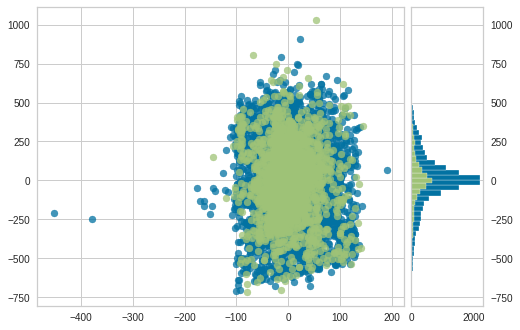

In [64]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(lr)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
#visualizer.show()                 # Finalize and render the figure

A common use of the residuals plot is to analyze the variance of the error of the regressor. If the points are **randomly dispersed** around the horizontal axis, a **linear regression model** is usually appropriate for the data; otherwise, a **non-linear model is more appropriate.**

In the case above, we see a **random, uniform distribution** of the **residuals** against the **target** in two dimensions. This seems to indicate that our **linear model is performing in an acceptable way but not that good**. We can also see from the **histogram** that our **error** is **normally distributed around zero**, which also generally indicates an **acceptable fitted model**.

Now let's predict on **test dataset**

In [65]:
preds=lr.predict(test) 

In [66]:
Predictions=pd.DataFrame()

In [67]:
Predictions["Id"]=test_ID
Predictions["next_day_ret"]=preds

In [68]:
Predictions.head()

,Id,next_day_ret
0,20417,-12.982519
1,20418,-7.186462
2,20419,-3.203593
3,20420,-0.312440
4,20421,34.447117


In [69]:
#Predictions.to_csv("predictions.csv",index=False)